In [1]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torchvision
from fastai import *
from fastai.vision import *
import numpy as np


#processing tokens
import unicodedata 
import re
import inflect 

#tokenize
from nltk import word_tokenize, sent_tokenize

#find ngrams
from nltk.util import ngrams

import time
from tqdm import tqdm

#nn
import torch.nn as nn
from torch import optim
from sklearn import preprocessing

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())


GeForce GTX 1060 6GB
True


# load inputs from pickle file

In [13]:
inputs = torch.load('../../pickles/input_2648573_dev_file').transpose(-2,1).float()
outputs = torch.load('../../pickles/output_2648573_dev_file').flatten().float()
inputs = 1/inputs

In [15]:
x = 501
print(inputs[x:x+1,:])
#print(outputs[x].reshape(1,1).size())
#print(outputs[x].reshape(1,1))
print(outputs[x])
print(inputs.size())

print(outputs.size())

if device.type == 'cuda':
    #print(torch.cuda.get_device_name(0))
    print('\nMemory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,1), 'MB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**2,1), 'MB')

tensor([[1.5152e-02, 2.5000e-01, 3.9324e-04, 5.2967e-06]], device='cuda:0')
tensor(0.0406, device='cuda:0')
torch.Size([2648573, 4])
torch.Size([2648573])

Memory Usage:
Allocated: 50.5 MB
Cached:    182.0 MB


# Neural Net


In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        #self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 3)
        self.fc4 = nn.Linear(3, 1)

        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        #x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x)) 
        x = torch.sigmoid(self.fc4(x)) 
        return x

In [228]:
net = Net().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.75)
#criterion = torch.nn.SmoothL1Loss()  
#criterion = torch.nn.L1Loss()  #mean absolute error
criterion = torch.nn.MSELoss()  #mean square error
#criterion = torch.nn.NLLLoss   #neg log likelyhood


In [229]:
start = time.time()

#for epoch in range(0, 1): ## run the model for 10 epochs

for x in tqdm(range(len(inputs)),position=0, leave=True): #x starts at zero

    if x%10 ==1:
        optimizer.zero_grad()

        ## 1. forward propagation
        net_out = net((inputs[x:x+1,:]))
        #print(train[:,x:(x+1)])

        ## 2. loss calculation
        loss = criterion(net_out, outputs[x].reshape(1,1))
        #print(target[x])

        ## 3. backward propagation
        loss.backward()

        ## 4. weight optimization
        optimizer.step()
        
        #if(x % 10000 == 1):
        #    print('Loss: {:.6f}'.format(loss.data))
        
        
end = time.time()
print(end-start)

100%|██████████| 6903410/6903410 [15:41<00:00, 7329.31it/s]

941.8923707008362


# Saving Model

In [6]:
torch.save(net.state_dict(), 'NN saves/temp')

NameError: name 'net' is not defined

# Loading model

In [53]:
net = Net().cuda()
net.load_state_dict(torch.load('NN saves/mse_4431_lr=0.01_m=0.1_without_r=1'))
net.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'NN saves/mse_4431_lr=0.01_m=0.1_without_r=1'

# Fast AI

In [167]:
class ArrayDataset(Dataset):
    "Sample numpy array dataset"
    def __init__(self, x, y):
        self.x = x
        self.y = y   
        self.c = 1 # binary label
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i,:], self.y[i].reshape(1)

In [168]:
fastAI_inputs = inputs[0:1000000,:].to("cpu")
fastAI_outputs = outputs[0:1000000].to("cpu")
fastAI_inputs2 = inputs[1000000:2000000,:].to("cpu")
fastAI_outputs2 = outputs[1000000:2000000].to("cpu")

print(fastAI_inputs[1:2,:].size())
print(fastAI_outputs[1].size())

torch.Size([1, 4])
torch.Size([])


In [169]:
train_ds = ArrayDataset(fastAI_inputs,fastAI_outputs)
valid_ds = ArrayDataset(fastAI_inputs2,fastAI_outputs2)
data = DataBunch.create(train_ds, valid_ds, bs=2)
print(data.one_batch())


(tensor([[7.5188e-03, 5.0000e-01, 2.1277e-02, 2.2642e-06],
        [2.3810e-02, 5.0000e-01, 5.5556e-02, 1.2798e-06]]), tensor([[0.0078],
        [0.0248]]))


In [191]:
criterion = torch.nn.MSELoss()  #mean square error
#criterion = torch.nn.L1Loss()  #mean absolute error
#criterion = torch.nn.SmoothL1Loss()  
#criterion = torch.nn.NLLLoss()   #neg log likelyhood
#criterion = torch.nn.CrossEntropyLoss()
net2 = Net().cuda()

In [192]:
learn = Learner(data, net2, opt_func = torch.optim.SGD, loss_func = criterion)

In [193]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


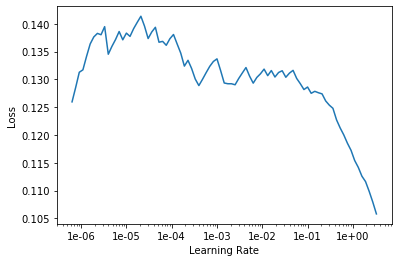

In [194]:
learn.recorder.plot()

# Comparing 

In [50]:
start = time.time()

difference = np.zeros(int(len(inputs)/10)+1)
net_results = np.zeros(int(len(inputs)/10)+1)
actual_results = np.zeros(int(len(inputs)/10)+1)
count = 0

for x in tqdm(range(len(inputs)),position=0, leave=True):
    if x%10 == 1:
        net_results[count] = net(inputs[x:x+1,:])
        actual_results[count] = outputs[x]
        difference[count] = abs(net_results[count] - actual_results[count])/actual_results[count]
        count += 1

net_results.sort()
actual_results.sort()
difference.sort()

end = time.time()
print('time: ' + str(end-start))

100%|██████████| 2648573/2648573 [01:06<00:00, 39546.29it/s]


time: 67.01775574684143


In [52]:
print(net_results)
print(actual_results)

[0.01157  0.01157  0.011571 0.011571 ... 0.714345 0.714345 0.714345 0.714345]
[5.888951e-06 5.888951e-06 5.888951e-06 5.888951e-06 ... 8.428460e-01 8.428460e-01 8.428460e-01 8.428460e-01]


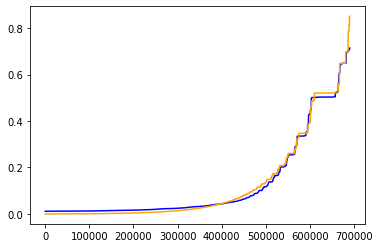

In [206]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

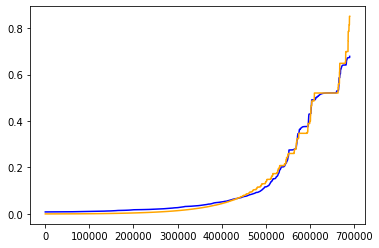

In [231]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

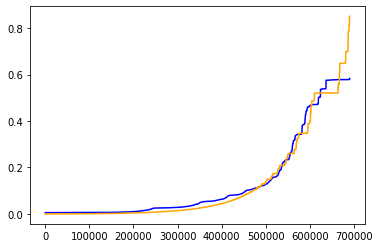

In [224]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

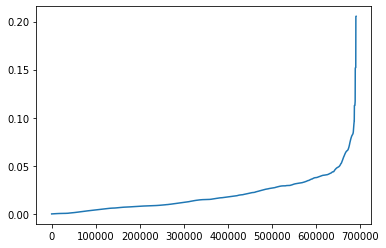

In [232]:
plt.plot(difference)
plt.show()

In [233]:
print(net(torch.tensor([7.5188e-03, 5.0000e-01, 2.1277e-02, 2.2642e-06], device = device)))#0.0078
print(net(torch.tensor([2.3810e-02, 5.0000e-01, 5.5556e-02, 1.2798e-06], device = device)))#0.0248

tensor([0.0103], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.0152], device='cuda:0', grad_fn=<SigmoidBackward>)


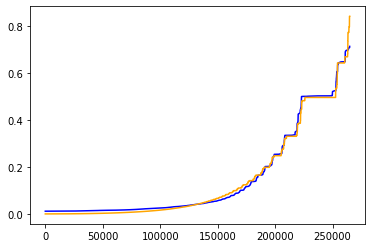

In [21]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

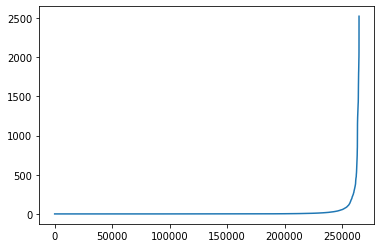

In [51]:
plt.plot(difference)
plt.show()